<a href="https://colab.research.google.com/github/Prabhatkumar7905/US_Flight_Delay_Analysis_prabhat/blob/main/Insights_in_Flight_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Exploratory data analysis of US Flight delays**

TASK: Analyze flights for insights on delays.

In [112]:
# Data Loading and Numerical Operations
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
%matplotlib inline

# processing tools
import statsmodels.formula.api as smf
import calendar
import datetime as dt

# Machine learning
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# pd.options.display.float_format = '{:,.2f}'.format

In [113]:
df = pd.read_csv('/content/drive/MyDrive/flight_2019.csv')
df_20 = pd.read_csv('/content/drive/MyDrive/flights_2020.csv')

In [114]:
#Parsing Dates
# 2019
df['Date'] = pd.to_datetime('2019-01-' + df['DAY_OF_MONTH'].apply(str))
df['day_name'] = df['Date'].dt.day_name()
# 2020
df_20['Date'] = pd.to_datetime('2020-01-' + df_20['DAY_OF_MONTH'].apply(str))
df_20['day_name'] = df_20['Date'].dt.day_name()

In [115]:
df.head()

,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,OP_CARRIER_AIRLINE_ID,OP_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN_AIRPORT_SEQ_ID,ORIGIN,...,DEP_DEL15,DEP_TIME_BLK,ARR_TIME,ARR_DEL15,CANCELLED,DIVERTED,DISTANCE,Unnamed: 21,Date,day_name
0,1,2,9E,20363,9E,N8688C,3280,11953,1195302,GNV,...,0.0,0600-0659,722.0,0.0,0.0,0.0,300.0,NaN,2019-01-01,Tuesday
1,1,2,9E,20363,9E,N348PQ,3281,13487,1348702,MSP,...,0.0,1400-1459,1633.0,0.0,0.0,0.0,596.0,NaN,2019-01-01,Tuesday
2,1,2,9E,20363,9E,N8896A,3282,11433,1143302,DTW,...,0.0,1200-1259,1329.0,0.0,0.0,0.0,229.0,NaN,2019-01-01,Tuesday
3,1,2,9E,20363,9E,N8886A,3283,15249,1524906,TLH,...,0.0,1500-1559,1625.0,0.0,0.0,0.0,223.0,NaN,2019-01-01,Tuesday
4,1,2,9E,20363,9E,N8974C,3284,10397,1039707,ATL,...,0.0,1900-1959,1940.0,0.0,0.0,0.0,579.0,NaN,2019-01-01,Tuesday


### Mapping weekday from numbers to names will make it easier and faster to understand.

In [116]:
mapping = {1:'Monday', 2:'Tuesday', 3:'Wednesday', 4: 'Thursday', 5: 'Friday', 6: 'Saturday', 7: 'Sunday'}
df['WEEKDAY'] = df.DAY_OF_WEEK.map(mapping)

# mapping2 = {'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'}
# df['WEEKDAY'] = pd.Categorical(df.DAY_OF_WEEK, categories= mapping2, ordered=True)
# df['DAY_OF_WEEK'] = pd.Categorical(bc['DAY_OF_WEEK'], categories=
#     ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday'],
#     ordered=True)


df.WEEKDAY.describe()

count       583985
unique           7
top       Thursday
freq         99387
Name: WEEKDAY, dtype: object

### Thursday was the most traveled weekday for Jan 2019

In [117]:
# df.WEEKDAY.head()
df.WEEKDAY.value_counts(normalize=True)*100
df.WEEKDAY.unique()

array(['Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday',
       'Monday'], dtype=object)

In [118]:
df.DEP_TIME_BLK.describe()

count        583985
unique           19
top       0600-0659
freq          41971
Name: DEP_TIME_BLK, dtype: object

In [119]:
df.DEP_TIME_BLK.unique()

array(['0600-0659', '1400-1459', '1200-1259', '1500-1559', '1900-1959',
       '0900-0959', '1000-1059', '2000-2059', '1300-1359', '1100-1159',
       '0800-0859', '2200-2259', '1600-1659', '1700-1759', '2100-2159',
       '0700-0759', '1800-1859', '0001-0559', '2300-2359'], dtype=object)

In [120]:
df_20.DEP_TIME_BLK.unique()

array(['1000-1059', '1800-1859', '0600-0659', '1600-1659', '1400-1459',
       '1900-1959', '1100-1159', '0700-0759', '2100-2159', '1500-1559',
       '0900-0959', '1700-1759', '1200-1259', '0800-0859', '0001-0559',
       '2000-2059', '1300-1359', '2200-2259', '2300-2359'], dtype=object)

### Military time is used in flight data, will also map the time to 12 hour to also make easier to understand.

In [121]:
maptimeblk = {
            '0001-0559':'1AM-5:59AM',
            '0600-0659':'6-6:59AM',
            '0700-0759':'7-7:59AM',
            '0800-0859':'8-8:59AM',
            '0900-0959':'9-9:59AM',
            '1000-1059':'10-10:59AM',
            '1100-1159':'11-11:59AM',
            '1200-1259':'12-12:59PM',
            '1300-1359':'1-1:59PM',
            '1400-1459':'2-2:59PM', 
            '1500-1559':'3-3:59PM',
            '1600-1659':'4-4:59PM',
            '1700-1759':'5-5:59PM',
            '1800-1859':'6-6:59PM',
            '1900-1959':'7-7:59PM',
            '2000-2059':'8-8:59PM',
            '2100-2159':'9-9:59PM',
            '2200-2259':'10-10:59PM',
            '2300-2359':'11-11:59PM'
             }
df['timeblk'] = df.DEP_TIME_BLK.map(maptimeblk)


df.timeblk.describe()

count       583985
unique          19
top       6-6:59AM
freq         41971
Name: timeblk, dtype: object

In [122]:
# df.drop('timeblk2', axis=1, inplace=True)

In [123]:
maptimeblk2 = {
            '0001-0559':'1AM-5:59AM',
            '0600-0659':'6-6:59AM',
            '0700-0759':'7-7:59AM',
            '0800-0859':'8-8:59AM',
            '0900-0959':'9-9:59AM',
            '1000-1059':'10-10:59AM',
            '1100-1159':'11-11:59AM',
            '1200-1259':'12-12:59PM',
            '1300-1359':'1-1:59PM',
            '1400-1459':'2-2:59PM', 
            '1500-1559':'3-3:59PM',
            '1600-1659':'4-4:59PM',
            '1700-1759':'5-5:59PM',
            '1800-1859':'6-6:59PM',
            '1900-1959':'7-7:59PM',
            '2000-2059':'8-8:59PM',
            '2100-2159':'9-9:59PM',
            '2200-2259':'10-10:59PM',
            '2300-2359':'11-11:59PM'
             }
df_20['timeblk'] = df_20.DEP_TIME_BLK.map(maptimeblk2)


df_20.timeblk.describe()

count       607346
unique          19
top       6-6:59AM
freq         44275
Name: timeblk, dtype: object

In [124]:
mapping20 = {1:'Monday', 2:'Tuesday', 3:'Wednesday', 4: 'Thursday', 5: 'Friday', 6: 'Saturday', 7: 'Sunday'}
df_20['WEEKDAY'] = df_20.DAY_OF_WEEK.map(mapping20)


df_20.WEEKDAY.describe()

count     607346
unique         7
top       Friday
freq      103812
Name: WEEKDAY, dtype: object

In [125]:
df.WEEKDAY.unique()

array(['Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday',
       'Monday'], dtype=object)

In [126]:
df_20.head()

,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,OP_CARRIER_AIRLINE_ID,OP_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN_AIRPORT_SEQ_ID,ORIGIN,...,ARR_TIME,ARR_DEL15,CANCELLED,DIVERTED,DISTANCE,Unnamed: 21,Date,day_name,timeblk,WEEKDAY
0,1,3,EV,20366,EV,N48901,4397,13930,1393007,ORD,...,1117.0,0.0,0.0,0.0,174.0,NaN,2020-01-01,Wednesday,10-10:59AM,Wednesday
1,1,3,EV,20366,EV,N16976,4401,15370,1537002,TUL,...,1216.0,0.0,0.0,0.0,585.0,NaN,2020-01-01,Wednesday,10-10:59AM,Wednesday
2,1,3,EV,20366,EV,N12167,4404,11618,1161802,EWR,...,2120.0,0.0,0.0,0.0,631.0,NaN,2020-01-01,Wednesday,6-6:59PM,Wednesday
3,1,3,EV,20366,EV,N14902,4405,10781,1078105,BTR,...,2004.0,0.0,0.0,0.0,253.0,NaN,2020-01-01,Wednesday,6-6:59PM,Wednesday
4,1,3,EV,20366,EV,N606UX,4407,14524,1452401,RIC,...,1330.0,0.0,0.0,0.0,1157.0,NaN,2020-01-01,Wednesday,10-10:59AM,Wednesday


### There are some nulls in the data, 1 unnamed column is all nulls we can drop, we have the correct datatype for date, weekday names, and 12 hour time blocks.

In [127]:
df.drop(['Unnamed: 21', 'OP_UNIQUE_CARRIER', 'TAIL_NUM', 'OP_CARRIER_AIRLINE_ID', 'OP_CARRIER_FL_NUM', 'ORIGIN_AIRPORT_ID', 'ORIGIN_AIRPORT_SEQ_ID', 'DEST_AIRPORT_ID', 'DEST_AIRPORT_SEQ_ID', 'CANCELLED', 'DIVERTED'], axis=1, inplace=True)
df.dropna(inplace=True)
df_20.drop(['Unnamed: 21', 'OP_UNIQUE_CARRIER', 'TAIL_NUM', 'OP_CARRIER_AIRLINE_ID', 'OP_CARRIER_FL_NUM', 'ORIGIN_AIRPORT_ID', 'ORIGIN_AIRPORT_SEQ_ID', 'DEST_AIRPORT_ID', 'DEST_AIRPORT_SEQ_ID', 'CANCELLED', 'DIVERTED'], axis=1, inplace=True)
df_20.dropna(inplace=True)
df.drop(['Unnamed: 21'], axis=1, inplace=True)
df_20.dropna(inplace=True)
df.dropna(subset=['TAIL_NUM'], inplace=True)

KeyError: ignored

In [128]:
# Check for missing data
df.isna().sum()/len(df)*100

DAY_OF_MONTH    0.0
DAY_OF_WEEK     0.0
OP_CARRIER      0.0
ORIGIN          0.0
DEST            0.0
DEP_TIME        0.0
DEP_DEL15       0.0
DEP_TIME_BLK    0.0
ARR_TIME        0.0
ARR_DEL15       0.0
DISTANCE        0.0
Date            0.0
day_name        0.0
WEEKDAY         0.0
timeblk         0.0
dtype: float64

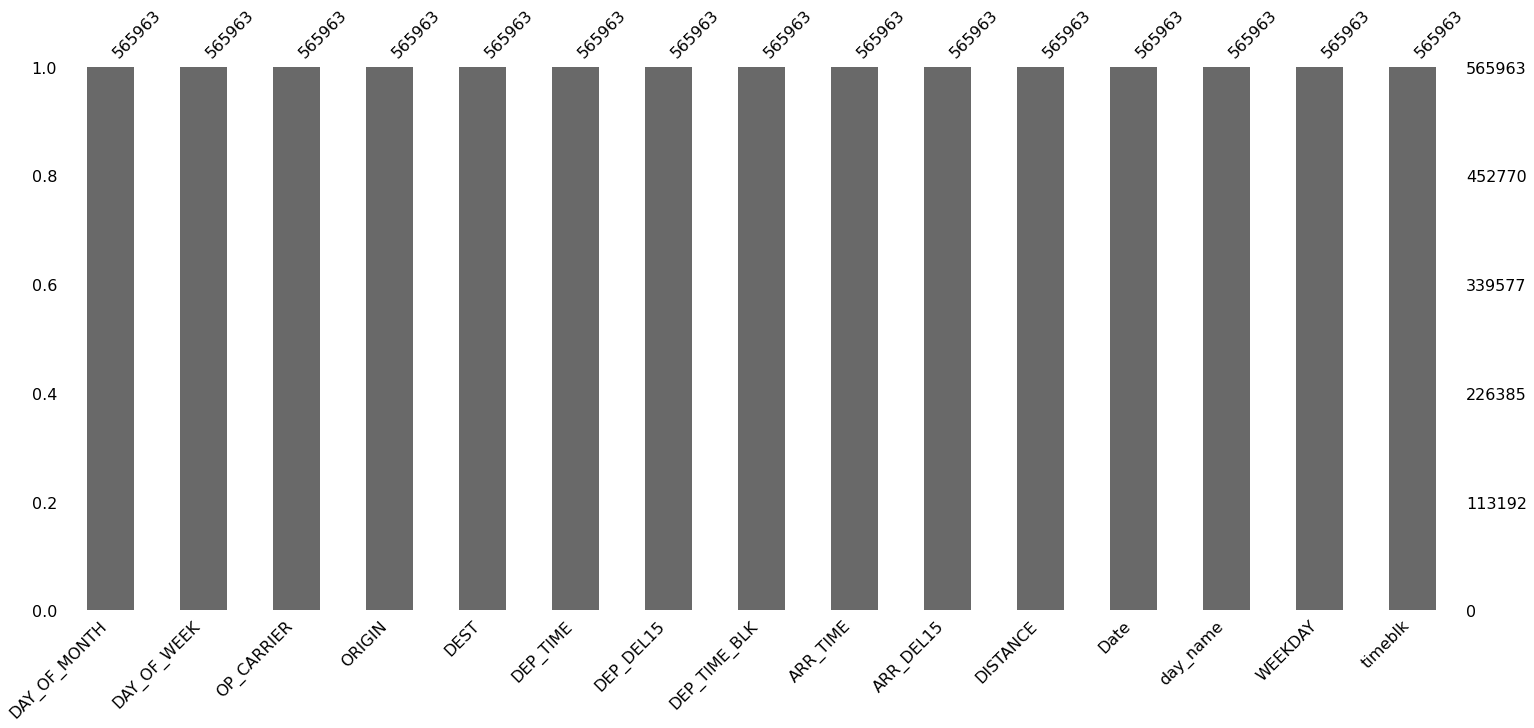

In [129]:
msno.bar(df)
# msno.bar(df_20)

In [131]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 565963 entries, 0 to 583984
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   DAY_OF_MONTH  565963 non-null  int64         
 1   DAY_OF_WEEK   565963 non-null  int64         
 2   OP_CARRIER    565963 non-null  object        
 3   ORIGIN        565963 non-null  object        
 4   DEST          565963 non-null  object        
 5   DEP_TIME      565963 non-null  float64       
 6   DEP_DEL15     565963 non-null  float64       
 7   DEP_TIME_BLK  565963 non-null  object        
 8   ARR_TIME      565963 non-null  float64       
 9   ARR_DEL15     565963 non-null  float64       
 10  DISTANCE      565963 non-null  float64       
 11  Date          565963 non-null  datetime64[ns]
 12  day_name      565963 non-null  object        
 13  WEEKDAY       565963 non-null  object        
 14  timeblk       565963 non-null  object        
dtypes: datetime64[ns]

### Dropped the null column, not many nulls in the others so I dropped those and any ID columns.

In [132]:
# df.DEP_DEL15.value_counts(normalize=True)*100
df_20.DEP_DEL15.value_counts(normalize=True)*100

0.0    86.408919
1.0    13.591081
Name: DEP_DEL15, dtype: float64

### 17% of Jan 2019 flights were delayed vs 13.5% in 2020

In [133]:
df.OP_CARRIER.value_counts(normalize=True)[:10]

WN    0.189474
AA    0.133143
DL    0.129696
OO    0.109141
UA    0.081500
YX    0.043411
MQ    0.041893
B6    0.041337
OH    0.039524
AS    0.035698
Name: OP_CARRIER, dtype: float64

In [134]:
top5 = df.groupby('OP_CARRIER')['DEP_DEL15'].sum().sort_values(ascending=False).head(5)
top5.sum() / totaldelays20 *100

NameError: ignored

In [135]:
### the top 5 airlines made up 61% of delays for 2019, 75% for 2020.

In [136]:
df.OP_CARRIER.unique()

array(['9E', 'AA', 'MQ', 'G4', 'OH', 'B6', 'YV', 'EV', 'F9', 'YX', 'HA',
       'NK', 'OO', 'WN', 'AS', 'UA', 'DL'], dtype=object)

In [137]:
# #Transform data types for 2019
# cols = ['DAY_OF_WEEK','DAY_OF_MONTH','DEP_DEL15','ARR_DEL15','CANCELLED','DIVERTED']
# for col in cols:
#   df[col] = df[col].astype('category') 

# #Discretization
df['DISTANCE_cat'] = pd.qcut(df['DISTANCE'], q=4)

In [138]:
# #Transform data types for 2020
# cols20 = ['DAY_OF_WEEK','DAY_OF_MONTH','DEP_DEL15','ARR_DEL15','CANCELLED','DIVERTED']
# for col in cols20:
#   df_20[col] = df_20[col].astype('category') 

# #Discretization
df_20['DISTANCE_cat'] = pd.qcut(df_20['DISTANCE'], q=4)

In [139]:

df.groupby('day_name')['DEP_DEL15'].sum()
#sum sums the 1s, count counts 0s and 1s (counting the number of flights)

day_name
Friday       13523.0
Monday       13485.0
Saturday      8766.0
Sunday       12493.0
Thursday     19029.0
Tuesday      14251.0
Wednesday    16758.0
Name: DEP_DEL15, dtype: float64

In [140]:
df.loc[df['day_name']=='Friday']['DISTANCE'].mean()

796.418630966003

In [142]:
df.loc[df['DEP_DEL15']==1.0]['DEP_DEL15'].sum()

98305.0

In [141]:
# Concentration of delays by carrier
# del_carr = df[['OP_CARRIER','DEP_DEL15']].groupby('OP_CARRIER').sum().sort_values(by='DEP_DEL15',ascending=False)
# del_carr['PERCENTUAL'] = del_carr['DEP_DEL15']/(del_carr['DEP_DEL15'].sum())*100
# del_carr

## Delays decreased 16.7% from Jan 2019 and Jan 2020.

In [143]:
(1-(avg_del20.sum() / avg_del19.sum()))*100

NameError: ignored

In [144]:
avg_del20.reset_index().plot(x='OP_CARRIER',y='PERCENTAGE',kind='barh')

KeyError: ignored

Delays by Origin 2019

In [145]:
orig_del19 = df[['ORIGIN','DEP_DEL15']].groupby('ORIGIN').sum()
orig_del19['PERCENTAGE'] = (orig_del19['DEP_DEL15'] / df.groupby('ORIGIN')['DEP_DEL15'].count()*100)
orig_del19 = orig_del19.sort_values(by='PERCENTAGE', ascending=False).head(20)
orig_del19

,DEP_DEL15,PERCENTAGE
ORIGIN,,
HGR,7.0,70.000000
OGS,6.0,60.000000
OGD,4.0,50.000000
LCK,19.0,46.341463
ASE,318.0,38.733252
SCK,20.0,38.461538
ART,18.0,38.297872
VEL,17.0,36.956522
MMH,27.0,36.486486


Delays by Origin 2020

In [146]:
orig_del20 = df_20[['ORIGIN','DEP_DEL15']].groupby('ORIGIN').sum()
orig_del20['PERCENTAGE'] = (orig_del20['DEP_DEL15'] / df_20.groupby('ORIGIN')['DEP_DEL15'].count()*100)
orig_del20 = orig_del20.sort_values(by='PERCENTAGE', ascending=False).head(20)
orig_del20

,DEP_DEL15,PERCENTAGE
ORIGIN,,
OGD,3.0,33.333333
PPG,3.0,33.333333
OTH,7.0,33.333333
ADK,3.0,33.333333
ASE,247.0,30.456227
PSM,6.0,30.000000
OGS,14.0,29.787234
RIW,14.0,29.166667
SUX,30.0,28.301887


Delays by destination 2019

In [147]:
dest_del19 = df[['DEST','DEP_DEL15']].groupby('DEST').sum()
dest_del19['PERCENTAGE'] = (dest_del19['DEP_DEL15'] / df.groupby('DEST')['DEP_DEL15'].count()*100)
dest_del19 = dest_del19.sort_values(by='PERCENTAGE', ascending=False).head(20)
dest_del19

,DEP_DEL15,PERCENTAGE
DEST,,
MKG,22.0,46.808511
HGR,4.0,40.000000
MMH,29.0,38.666667
PIB,23.0,38.333333
OGD,3.0,37.500000
HTS,7.0,35.000000
PSE,21.0,33.870968
AZA,149.0,32.964602
EAU,17.0,32.692308


Delays by destination 2020

In [148]:
dest_del20 = df_20[['DEST','DEP_DEL15']].groupby('DEST').sum()
dest_del20['PERCENTAGE'] = (dest_del20['DEP_DEL15'] / df_20.groupby('DEST')['DEP_DEL15'].count()*100)
dest_del20 = dest_del20.sort_values(by='PERCENTAGE', ascending=False).head(20)
dest_del20

,DEP_DEL15,PERCENTAGE
DEST,,
OTH,10.0,47.619048
ADQ,18.0,36.000000
IMT,17.0,30.909091
OGS,15.0,30.612245
ASE,250.0,29.069767
MEI,17.0,28.333333
LYH,23.0,27.710843
CAK,130.0,27.027027
AZA,130.0,26.694045


### Chicago (ORD) airport, Laguardia (LGA), Atlanta, San Francisco, Denver made up the busiest and most delayed airport destination in 2019.

In [149]:
dest_sum_del19 = df[['DEST','DEP_DEL15']].groupby('DEST').sum().sort_values(by='DEP_DEL15',ascending=False).head(20)
dest_sum_del19

,DEP_DEL15
DEST,
ORD,5488.0
LGA,4188.0
ATL,3698.0
SFO,3506.0
DFW,3463.0
EWR,3216.0
DEN,3001.0
LAX,2935.0
BOS,2575.0


### Shift among most delayed destinations, Charlotte Douglas Intl Airport at Charlotte North Carolina among the top 5 in 2020.

In [150]:
dest_sum_del20 = df_20[['DEST','DEP_DEL15']].groupby('DEST').sum().sort_values(by='DEP_DEL15',ascending=False).head(20)
dest_sum_del20

,DEP_DEL15
DEST,
DFW,3811.0
ORD,3547.0
ATL,3353.0
CLT,2785.0
SFO,2442.0
DEN,2441.0
LAX,2300.0
EWR,2210.0
LGA,2127.0



Total delays by ORIGIN 2019

In [151]:
org_sum_del19 = df[['ORIGIN','DEP_DEL15']].groupby('ORIGIN').sum().sort_values(by='DEP_DEL15',ascending=False).head(20)
org_sum_del19

,DEP_DEL15
ORIGIN,
ORD,6560.0
ATL,4118.0
DFW,4028.0
LGA,3775.0
DEN,3415.0
LAX,3017.0
SFO,2967.0
CLT,2671.0
EWR,2532.0


Total delays by ORIGIN 2020

In [152]:
org_sum_del20 = df_20[['ORIGIN','DEP_DEL15']].groupby('ORIGIN').sum().sort_values(by='DEP_DEL15',ascending=False).head(20)
org_sum_del20

,DEP_DEL15
ORIGIN,
DFW,4531.0
ORD,4079.0
ATL,3619.0
CLT,3046.0
DEN,2739.0
LAX,2377.0
SFO,2313.0
SEA,2264.0
EWR,2001.0


In [153]:
df.groupby('DEST')['DEP_DEL15'].sum().sort_values(ascending=False)

DEST
ORD    5488.0
LGA    4188.0
ATL    3698.0
SFO    3506.0
DFW    3463.0
        ...  
PPG       1.0
CPR       1.0
ADK       1.0
SMX       1.0
STC       0.0
Name: DEP_DEL15, Length: 346, dtype: float64

In [ ]:
# avg carrier delays 2019
# avg_del19 = (df.groupby('OP_CARRIER')['DEP_DEL15'].sum() / df.groupby('OP_CARRIER')['DEP_DEL15'].count() * 100).sort_values(ascending=False)
# avg_del19

In [154]:
# avg carrier delays 2020
avg_del20 = (df_20.groupby('OP_CARRIER')['DEP_DEL15'].sum() / df_20.groupby('OP_CARRIER')['DEP_DEL15'].count() * 100).sort_values(ascending=False)
avg_del20

OP_CARRIER
OH    19.321638
AS    18.442958
G4    17.865066
MQ    16.820914
YV    15.893092
OO    15.467403
F9    15.285900
B6    15.084684
AA    14.516642
NK    13.794496
UA    12.774110
WN    12.376054
EV    12.268697
9E    11.174036
YX    10.254631
DL    10.096587
HA     7.940128
Name: DEP_DEL15, dtype: float64

In [155]:

df.columns

Index(['DAY_OF_MONTH', 'DAY_OF_WEEK', 'OP_CARRIER', 'ORIGIN', 'DEST',
       'DEP_TIME', 'DEP_DEL15', 'DEP_TIME_BLK', 'ARR_TIME', 'ARR_DEL15',
       'DISTANCE', 'Date', 'day_name', 'WEEKDAY', 'timeblk', 'DISTANCE_cat'],
      dtype='object')

### Most delays occurred during the evening hours between 4-7pm most delays.

In [156]:
# Concentration of delays due to 'DEP_TIME_BLK'?
time_blk = df[['DEP_TIME_BLK','ARR_DEL15']].groupby('DEP_TIME_BLK').sum().sort_values(by='ARR_DEL15',ascending=False)
time_blk['PERCENTAGE'] = time_blk['ARR_DEL15']/(time_blk['ARR_DEL15'].sum())*100
time_blk

,ARR_DEL15,PERCENTAGE
DEP_TIME_BLK,,
1700-1759,8270.0,7.859573
1800-1859,7978.0,7.582065
1600-1659,7576.0,7.200015
1400-1459,7290.0,6.928209
1500-1559,7281.0,6.919656
1900-1959,7219.0,6.860733
1200-1259,6639.0,6.309517
1300-1359,6398.0,6.080477
1100-1159,6361.0,6.045314


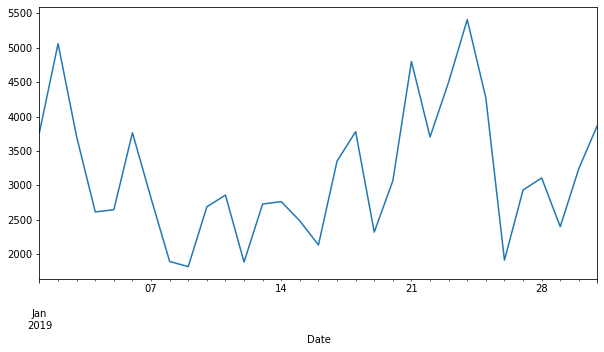

In [157]:
plt.figure(figsize=(10,5))
df.resample('D', on='Date').DEP_DEL15.sum().plot()

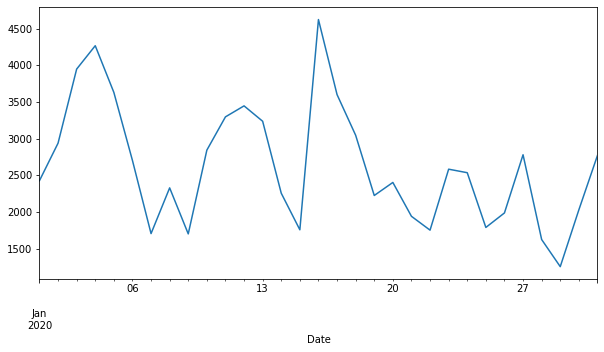

In [158]:
# data re-sampled based on an each week, just change the frequency
plt.figure(figsize=(10,5))
delays20 = df_20.resample('D', on='Date').DEP_DEL15.sum()
delays20.plot()

In [ ]:
# Exporting the prepared dataset to csv to visualize in Tableau.

# df.to_csv('flights_19.csv', index=False)
# df_20.to_csv('flights_20.csv', index=False)

In [ ]:
# DEP_DEL15 ~ ['DAY_OF_MONTH', 'DAY_OF_WEEK', 'OP_UNIQUE_CARRIER', 'OP_CARRIER_AIRLINE_ID', 'OP_CARRIER', 'TAIL_NUM', 'OP_CARRIER_FL_NUM',
#        'ORIGIN_AIRPORT_ID', 'ORIGIN_AIRPORT_SEQ_ID', 'ORIGIN',
#        'DEST_AIRPORT_ID', 'DEST_AIRPORT_SEQ_ID', 'DEST', 'DEP_TIME',
#        , 'DEP_TIME_BLK', 'ARR_TIME', 'ARR_DEL15',
#        'DIVERTED', 'DISTANCE']

In [159]:

df.columns

Index(['DAY_OF_MONTH', 'DAY_OF_WEEK', 'OP_CARRIER', 'ORIGIN', 'DEST',
       'DEP_TIME', 'DEP_DEL15', 'DEP_TIME_BLK', 'ARR_TIME', 'ARR_DEL15',
       'DISTANCE', 'Date', 'day_name', 'WEEKDAY', 'timeblk', 'DISTANCE_cat'],
      dtype='object')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


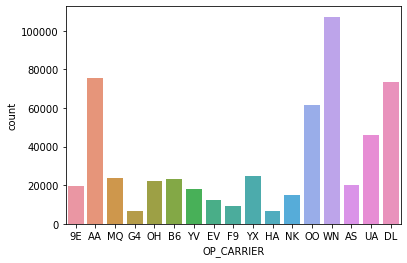

In [160]:
sns.countplot('OP_CARRIER', data=df)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


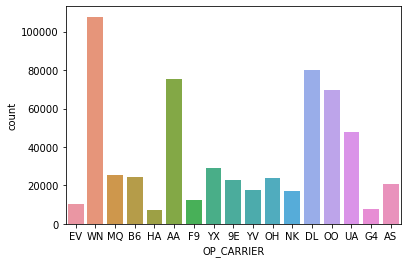

In [161]:
sns.countplot('OP_CARRIER', data=df_20)

Delays by airline

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


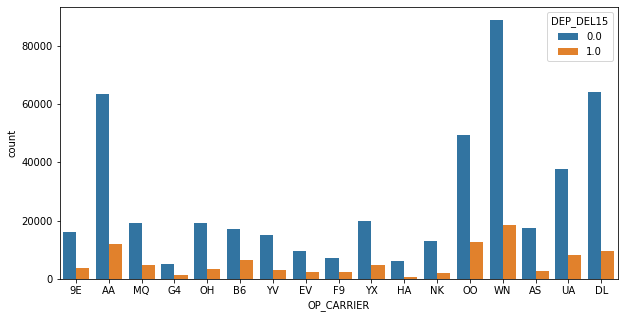

In [162]:

plt.figure(figsize=(10,5))
sns.countplot('OP_CARRIER', data=df, hue='DEP_DEL15')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


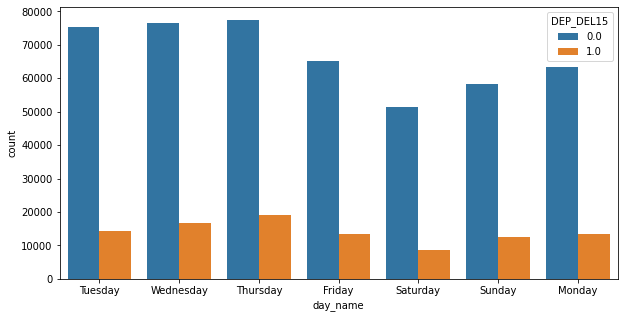

In [163]:
plt.figure(figsize=(10,5))
sns.countplot('day_name', data=df, hue='DEP_DEL15')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


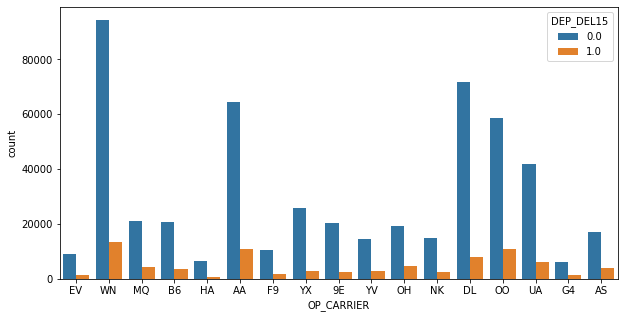

In [164]:
plt.figure(figsize=(10,5))
sns.countplot('OP_CARRIER', data=df_20, hue='DEP_DEL15')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


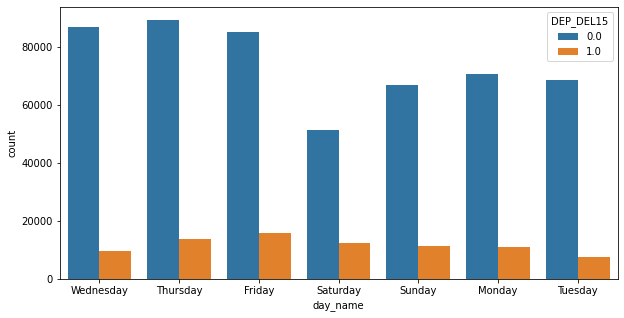

In [165]:
plt.figure(figsize=(10,5))
sns.countplot('day_name', data=df_20, hue='DEP_DEL15')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


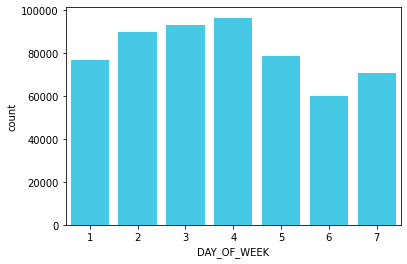

In [166]:
sns.countplot('DAY_OF_WEEK', data=df, color='#2ADAFF')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


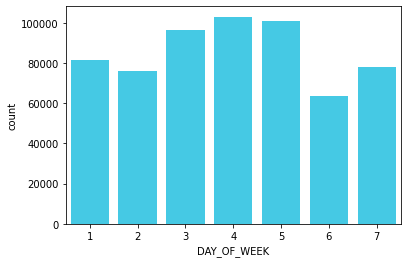

In [167]:
sns.countplot('DAY_OF_WEEK', data=df_20, color='#2ADAFF')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


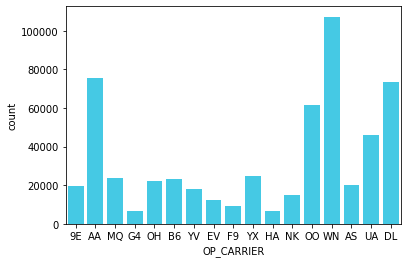

In [169]:
sns.countplot('OP_CARRIER', data=df, color='#2ADAFF')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


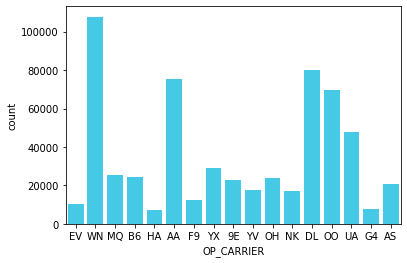

In [168]:
sns.countplot('OP_CARRIER', data=df_20, color='#2ADAFF')

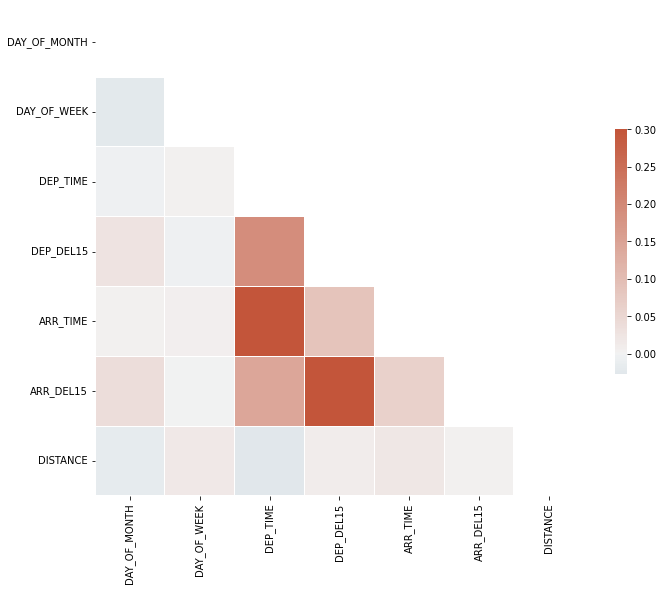

In [170]:
# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

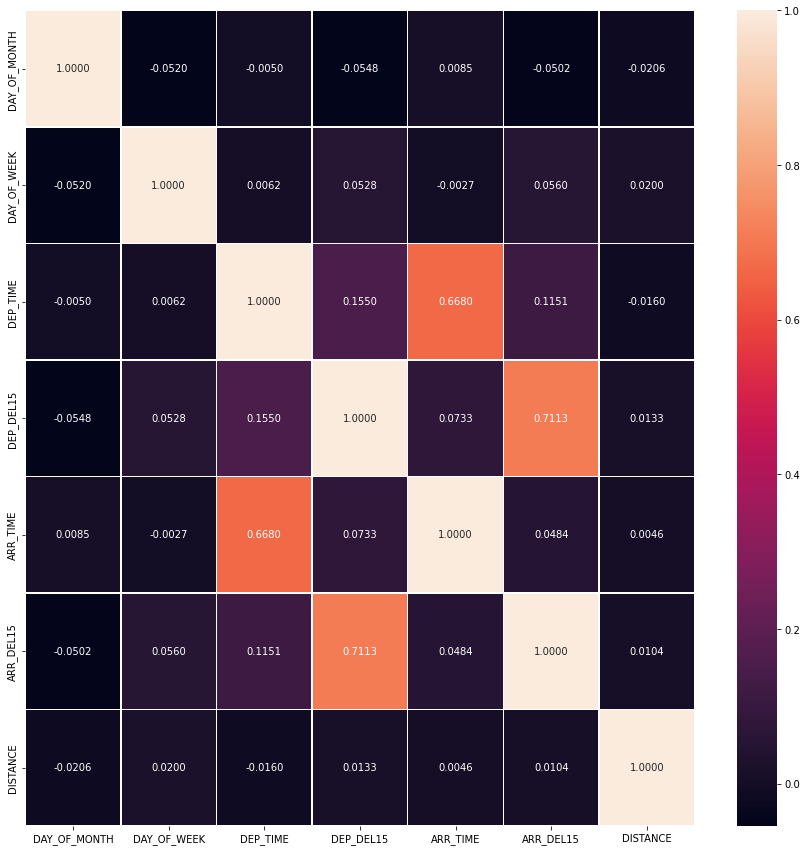

In [171]:

f, ax= plt.subplots(figsize=(15,15))
sns.heatmap(df_20.corr(),linewidths=.5,annot=True,fmt='.4f', ax=ax)
plt.show()

,DAY_OF_MONTH,DAY_OF_WEEK,DEP_TIME,DEP_DEL15,ARR_TIME,ARR_DEL15,DISTANCE
DAY_OF_MONTH,1.000000,-0.021999,-0.001515,0.027762,0.003527,0.038639,-0.016014
DAY_OF_WEEK,-0.021999,1.000000,0.003763,-0.003089,0.005355,-0.000655,0.017024
DEP_TIME,-0.001515,0.003763,1.000000,0.190526,0.672891,0.143283,-0.026949
DEP_DEL15,0.027762,-0.003089,0.190526,1.000000,0.088508,0.719430,0.011393
ARR_TIME,0.003527,0.005355,0.672891,0.088508,1.000000,0.062031,0.020906
ARR_DEL15,0.038639,-0.000655,0.143283,0.719430,0.062031,1.000000,0.003407
DISTANCE,-0.016014,0.017024,-0.026949,0.011393,0.020906,0.003407,1.000000


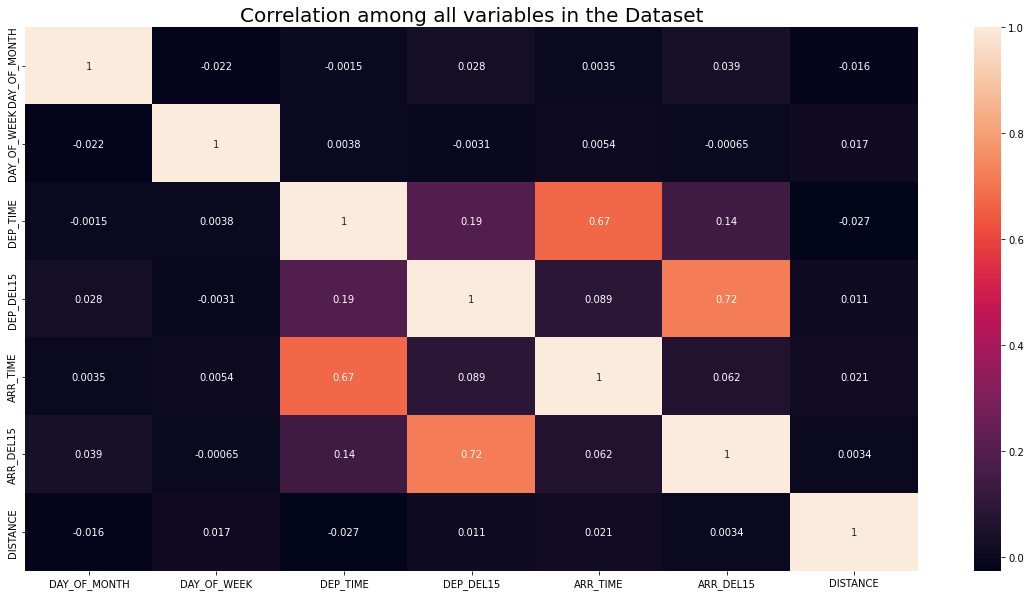

In [172]:

#Checking relationship between variables
cor=df.corr()
plt.figure(figsize=(20,10), facecolor='w')
sns.heatmap(cor,xticklabels=cor.columns,yticklabels=cor.columns,annot=True)
plt.title("Correlation among all variables in the Dataset", size=20)
cor

**Summary**

-The top 5 airlines made up 61% of delays for 2019, 75% for 2020.

-17% of Jan 2019 flights were delayed vs 13.5% in 2020.

-Delays decreased 16.7% from Jan 2019 and Jan 2020.

-Chicago (ORD) airport, Laguardia (LGA), Atlanta, San Francisco, Denver made up the busiest and most delayed airport by destination.

-Thursday was the most traveled weekday for Jan 2019, Friday for Jan 2020.

-Most delays occurred during the evening hours between 4-7pm most delays.